In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import anndata as ad
import pandas as pd
import os
import matplotlib.pyplot as plt

/home/users/zys/.local/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
PLT_CELL = 3.5

In [4]:
X = pd.read_csv('../tools/RENGE/examples/data/X_renge_d2_80.csv', index_col=0)
E = pd.read_csv('../tools/RENGE/examples/data/E_renge_d2_80.csv', index_col=0)

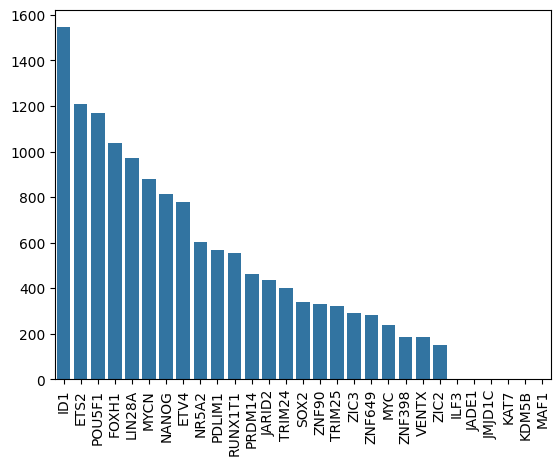

In [5]:
import seaborn as sb
sb.barplot(X.sum(0).sort_values()[::-1][1:30])
plt.xticks(rotation='vertical');

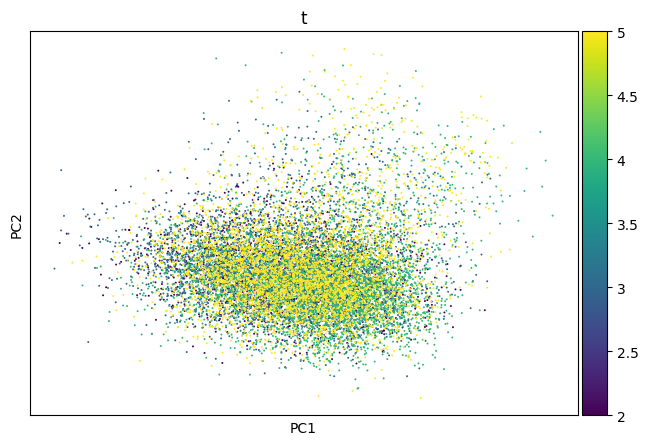

In [6]:
adata_ = ad.AnnData(E)
sc.pp.pca(adata_)
sc.pp.neighbors(adata_)

adata_.obs["t"] = X.t

# no KO
adata_.obs["condition"] = None
adata_.obs.loc[X.index[X.iloc[:, :-1].T.sum(0) == 0], "condition"] = "wt"

idx_ko = X.index[X.iloc[:, :-1].T.sum(0) == 1]
adata_.obs.loc[idx_ko, "condition"] = X.columns[np.argmax(X.loc[idx_ko, :].iloc[:, :-1], -1)]

sc.pl.scatter(adata_, basis = 'pca', color = 't')

In [7]:
import scipy as sp
import gzip
import glob
import pandas as pd
import os

In [ ]:
DATA_PATH = "../data/RENGE_data/"
X_all = []
for fname in np.sort(glob.glob(os.path.join(DATA_PATH, "day*/*.mtx.gz"))):
    print(fname)
    with gzip.open(fname, 'rt') as f:
        X_all.append(sp.io.mmread(f).T)
barcodes_all = []
for fname in np.sort(glob.glob(os.path.join(DATA_PATH, "day*/barcodes.tsv.gz"))):
    print(fname)
    with gzip.open(fname, 'rt') as f:
        barcodes_all.append(pd.read_csv(f, compression='gzip', delimiter='\t', header = None, index_col = 0))
        barcodes_all[-1].index.name = 'barcode'
features_all = []
for fname in np.sort(glob.glob(os.path.join(DATA_PATH, "day*/features.tsv.gz"))):
    print(fname)
    with gzip.open(fname, 'rt') as f:
        features_all.append(pd.read_csv(f, compression='gzip', delimiter='\t', header = None, index_col = 0))
        features_all[-1].columns = ['gene', 'type']
        features_all[-1].index.name = 'ens'

In [8]:
import anndata as ad
import scipy as sp
import scanpy as sc

adata_all = []
ts = [2, 3, 4, 5]
for i in range(len(X_all)):
    adata = ad.AnnData(sp.sparse.csr_matrix(X_all[i]), var = features_all[i], obs = barcodes_all[i])
    adata.obs["t"] = ts[i]
    adata_all.append(adata)

In [9]:
for t in range(len(ts)):
    A = set(adata_all[t].obs.index)
    B = set(X.index[X.index.str.startswith(f"{t+1}_")].str.split("_").str[1])
    idx = pd.Index(A.intersection(B))
    adata_all[t] = adata_all[t][idx, :]

    _df = X.loc[f'{t+1}_' + adata_all[t].obs.index, :].iloc[:, :-1].copy()
    _df.index = _df.index.str.split('_').str[1]

    _kos = pd.Series(["WT", ] * len(_df.index), index = _df.index)
    _kos[_df.values.sum(-1) > 0] = _df.columns[_df.values.argmax(-1)][_df.values.sum(-1) > 0]
    adata_all[t].obs["ko"] = _kos

/tmp/ipykernel_928420/3140330375.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_all[t].obs["ko"] = _kos
/tmp/ipykernel_928420/3140330375.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_all[t].obs["ko"] = _kos
/tmp/ipykernel_928420/3140330375.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_all[t].obs["ko"] = _kos
/tmp/ipykernel_928420/3140330375.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_all[t].obs["ko"] = _kos


In [10]:
adata = ad.concat(adata_all, index_unique="_")

In [11]:
df = adata_all[0].var
not_grna_idx = [x for x in df[df.type != "CRISPR Guide Capture"].index]

adata.var = adata_all[0].var

adata = adata[:, adata.var.loc[not_grna_idx].index]

In [12]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata)

/home/syz/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/syz/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


/home/syz/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):
/home/syz/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_utils.py:714: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


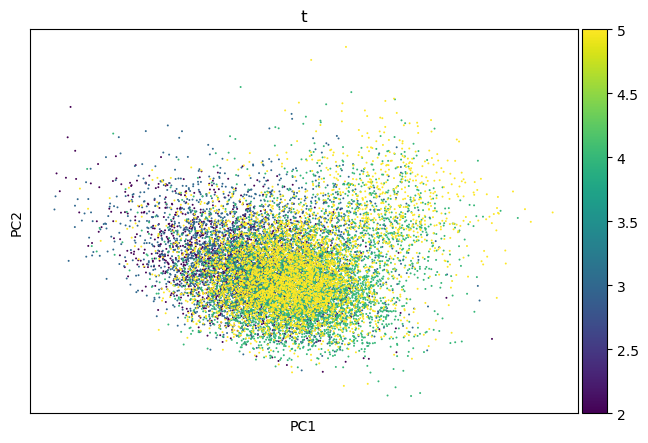

In [13]:
sc.pl.scatter(adata, basis = "pca", color = "t")

In [14]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/syz/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):
/home/syz/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_utils.py:714: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


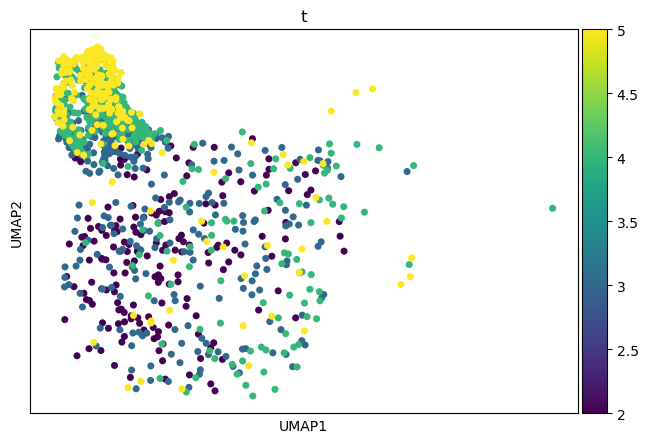

In [15]:
sc.pl.scatter(adata[adata.obs.ko == "POU5F1", :], basis = "umap", color = "t")

/home/syz/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):
/home/syz/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_utils.py:714: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


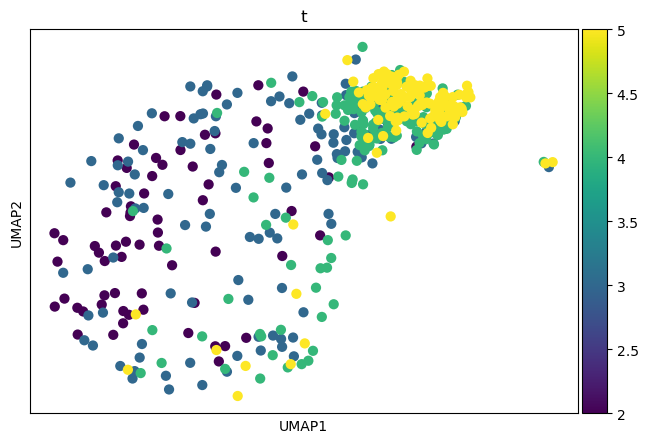

In [16]:
sc.pl.scatter(adata[adata.obs.ko == "RUNX1T1", :], basis = "umap", color = "t")

In [17]:
import dcor
dists_ko = pd.Series({k : dcor.energy_distance(adata.obsm["X_pca"][adata.obs.ko == "WT", :], adata.obsm["X_pca"][adata.obs.ko == k, :]) for k in adata.obs.ko.unique()})

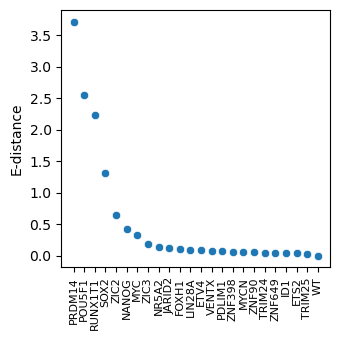

In [18]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
sb.scatterplot(dists_ko.sort_values()[::-1])
plt.ylabel("E-distance")
plt.xticks(rotation = 90, fontsize = 8);
plt.tight_layout()
plt.savefig("../figures/scCRISPR_Edists.pdf")

In [19]:
adata_tf = adata.copy()
adata_tf = adata_tf[:, pd.Index([x in E.columns for x in adata_tf.var.gene])]
adata_tf.var.index = adata_tf.var.gene

In [20]:
adata_tf[adata_tf.obs.ko == "POU5F1", :]

View of AnnData object with n_obs × n_vars = 1169 × 103
    obs: 't', 'ko'
    var: 'gene', 'type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [44]:
import sys
sys.path.append("../src/")
import importlib
import rf
importlib.reload(rf)
import torch

In [45]:
options = {
    "lr" : 0.1,
    "reg_sinkhorn" : 0.05,
    "reg_A" : 0.5e-3, 
    "reg_A_elastic" : 0.5,
    "iter" : 5_000,
    "ot_coupling" : True,
    "optimizer" : torch.optim.Adam,
    "n_pca_components" : 50
}

In [46]:
_kos = ["WT", ] + list(dists_ko.sort_values()[::-1][range(8)].index) 
_kos

/tmp/ipykernel_928420/491246595.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _kos = ["WT", ] + list(dists_ko.sort_values()[::-1][range(8)].index) # this works well


['WT', 'PRDM14', 'POU5F1', 'RUNX1T1', 'SOX2', 'ZIC2', 'NANOG', 'MYC', 'ZIC3']

/home/syz/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):
/home/syz/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


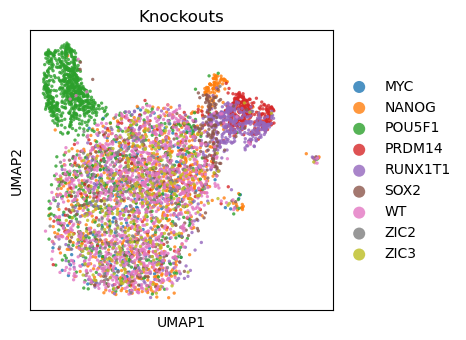

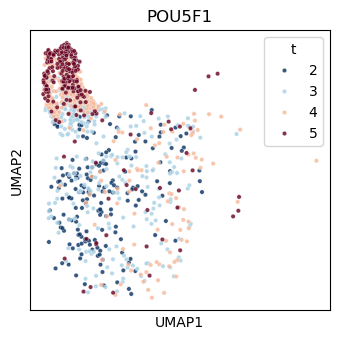

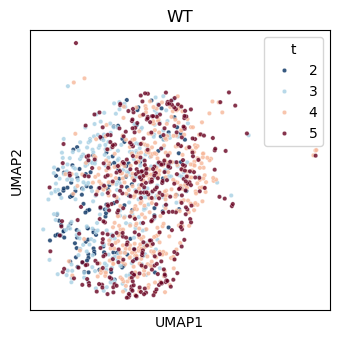

In [47]:
_adata = adata[adata.obs.ko.isin(_kos), :]

fig, ax = plt.subplots(1, 1, figsize=(1.36*PLT_CELL, PLT_CELL))
sc.pl.scatter(_adata, basis = "umap", color = "ko", show = False, ax = ax, alpha = 0.8)
plt.title("Knockouts")
plt.tight_layout()
plt.savefig("../figures/scCRISPR_knockouts_umap.pdf")
for g in ["POU5F1", "WT"]:
    fig, ax = plt.subplots(1, 1, figsize=(PLT_CELL, PLT_CELL))
    sb.scatterplot(x = _adata[_adata.obs.ko == g, :].obsm["X_umap"][:, 0], 
                   y = _adata[_adata.obs.ko == g, :].obsm["X_umap"][:, 1], 
                   hue = _adata[_adata.obs.ko == g].obs.t, palette="RdBu_r", alpha = 0.8, s = 10)
    plt.title(f"{g}")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.xticks([], []); plt.yticks([], [])
    plt.tight_layout()
    plt.savefig(f"../figures/scCRISPR_{g}_umap.pdf")

In [48]:
_adatas = []
for k in _kos:
    _adatas.append(adata_tf[adata_tf.obs.ko == k, :].copy())
    _adatas[-1].X = np.asarray(_adatas[-1].X.todense(), dtype = np.float64)
    _adatas[-1].obs.t -= 2
    _adatas[-1].var.index = _adatas[-1].var.gene
if _kos[0] == "WT":
    _kos[0] = None

In [49]:
estim_alt = rf.Estimator(_adatas, _kos, 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = options["ot_coupling"],
                           optimizer = options["optimizer"], 
                          n_pca_components = options["n_pca_components"])
estim_alt.fit(print_iter=100, alg = "alternating", update_couplings_iter=500);

/home/syz/Projects/temporal_perturb/notebooks/../src/rf.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(self.A, requires_grad = True, dtype = torch.float64)


Updating transport plans
iteration 0, loss = 30.052337217741847, L = 30.052337217741847, R = 0.0
iteration 100, loss = 12.426904242082932, L = 12.257027404831454, R = 339.75367450295437
iteration 200, loss = 12.103416320378285, L = 11.924999320994893, R = 356.8339987667834
iteration 300, loss = 12.049222742999351, L = 11.864304259429943, R = 369.83696713881704
iteration 400, loss = 12.035958369606078, L = 11.84726316585245, R = 377.3904075072557
iteration 500, loss = 10.083795172551788, L = 9.893090427170767, R = 381.40949076204305
iteration 600, loss = 9.725555701472368, L = 9.562644761665167, R = 325.8218796144012
iteration 700, loss = 9.677557951054194, L = 9.50521964565226, R = 344.67661080386546
iteration 800, loss = 9.661475213428465, L = 9.484408498053435, R = 354.1334307500613
iteration 900, loss = 9.654617944474447, L = 9.474606207997864, R = 360.0234729531654
iteration 1000, loss = 9.522623670840153, L = 9.340847864695576, R = 363.5516122891522
iteration 1100, loss = 9.482991

In [50]:
_adata_wt = []
for k in ["WT", ]:
    _adata_wt.append(adata_tf[adata_tf.obs.ko == k, :].copy())
    _adata_wt[-1].X = np.asarray(_adata_wt[-1].X.todense(), dtype = np.float64)
    _adata_wt[-1].obs.t -= 2
    _adata_wt[-1].var.index = _adata_wt[-1].var.gene
estim_wt = rf.Estimator(_adata_wt, [None, ], 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = options["ot_coupling"],
                           optimizer = options["optimizer"], 
                           n_pca_components=options["n_pca_components"])
estim_wt.fit(print_iter=100, alg = "alternating", update_couplings_iter=500);

/home/syz/Projects/temporal_perturb/notebooks/../src/rf.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(self.A, requires_grad = True, dtype = torch.float64)


Updating transport plans
iteration 0, loss = 27.229519316259413, L = 27.229519316259413, R = 0.0
iteration 100, loss = 9.841119997717508, L = 9.557191857866261, R = 567.8562797024917
iteration 200, loss = 9.506775400871062, L = 9.228416024868384, R = 556.7187520053565
iteration 300, loss = 9.450486129350699, L = 9.163991232502458, R = 572.9897936964836
iteration 400, loss = 9.436101347520705, L = 9.1457015035959, R = 580.7996878496097
iteration 500, loss = 7.850660225574129, L = 7.558860149799284, R = 583.6001515496885
iteration 600, loss = 7.359503426501221, L = 7.224962191354483, R = 269.08247029347694
iteration 700, loss = 7.317079122152373, L = 7.182765835339591, R = 268.6265736255648
iteration 800, loss = 7.303464739060083, L = 7.1684757692675225, R = 269.9779395851214
iteration 900, loss = 7.297673716011395, L = 7.16239163985063, R = 270.5641523215306
iteration 1000, loss = 7.062908912338406, L = 6.927725687008265, R = 270.3664506602813
iteration 1100, loss = 6.979265454271285, L

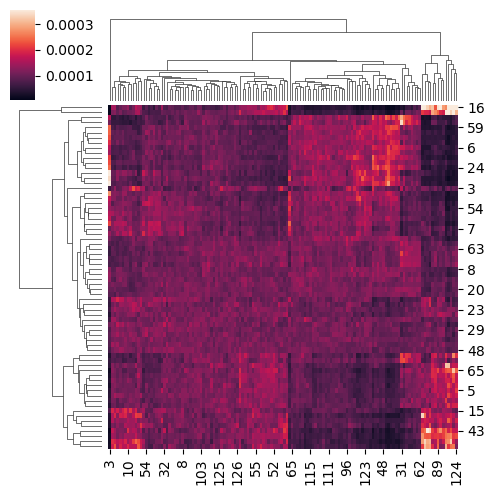

In [355]:
_T = estim_alt.Ts[3][0]
sb.clustermap(_T, figsize = (5, 5), vmax = np.quantile(_T, 0.999))

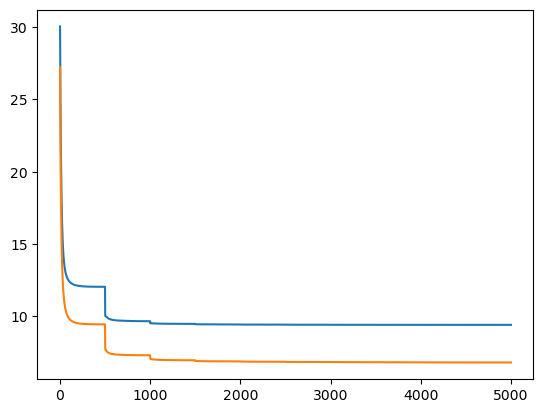

In [356]:
plt.plot(estim_alt.trace)
plt.plot(estim_wt.trace)

In [407]:
A_renge = pd.read_csv("A_renge_output.csv", index_col=0)

/home/syz/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/syz/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


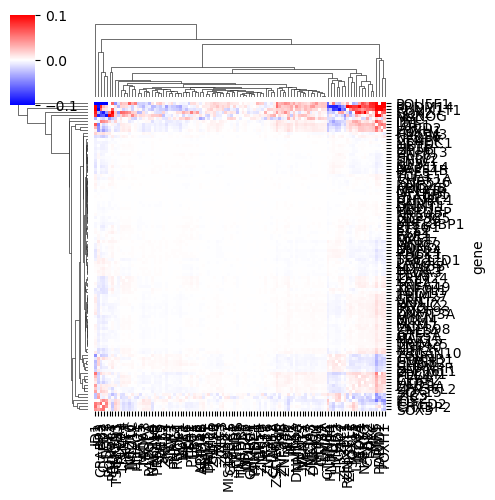

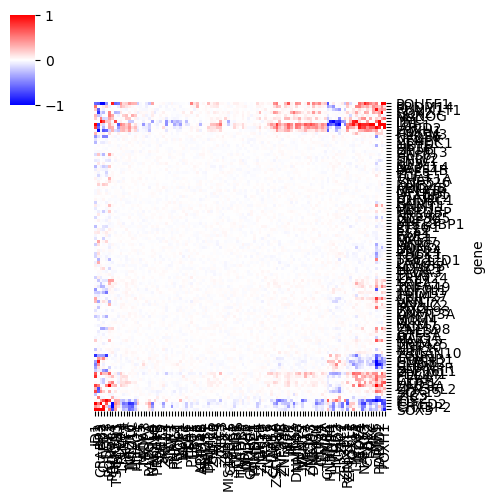

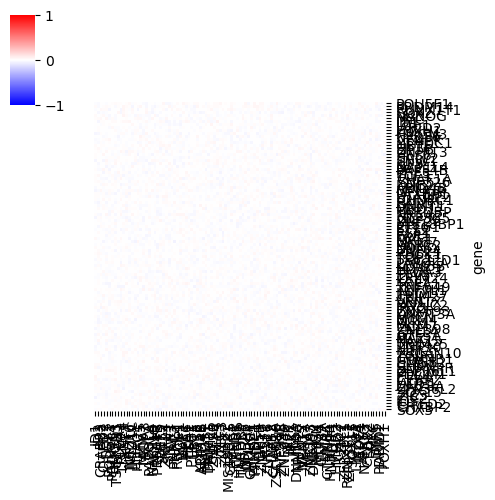

In [408]:
cg = sb.clustermap(A_renge, cmap = "bwr", vmin = -0.1, vmax = 0.1, figsize = (5, 5), xticklabels = 1, yticklabels = 1)
row_idx = A_renge.index[cg.dendrogram_row.reordered_ind]
col_idx = A_renge.columns[cg.dendrogram_col.reordered_ind]
sb.clustermap(pd.DataFrame(estim_alt.A, index = adata_tf.var.index, columns=adata_tf.var.index).loc[row_idx, col_idx], 
              vmin = -1, vmax = 1, cmap = "bwr", row_cluster=False, col_cluster=False, figsize = (5, 5), xticklabels = 1, yticklabels = 1)
sb.clustermap(pd.DataFrame(estim_wt.A, index = adata_tf.var.index, columns=adata_tf.var.index).loc[row_idx, col_idx], 
              vmin = -1, vmax = 1, cmap = "bwr", row_cluster=False, col_cluster=False, figsize = (5, 5), xticklabels = 1, yticklabels = 1)

/home/syz/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/syz/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


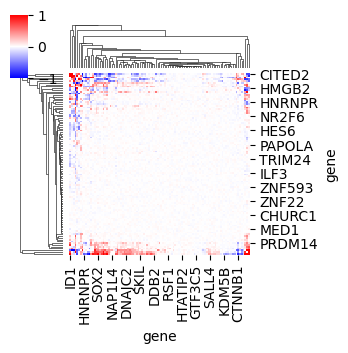

In [409]:
sb.clustermap(pd.DataFrame(estim_alt.A, index = adata_tf.var.index, columns=adata_tf.var.index), 
              vmin = -1, vmax = 1, cmap = "bwr", row_cluster=True, col_cluster=True, figsize = (PLT_CELL, PLT_CELL))
plt.savefig("../figures/scCRISPR_net.pdf")

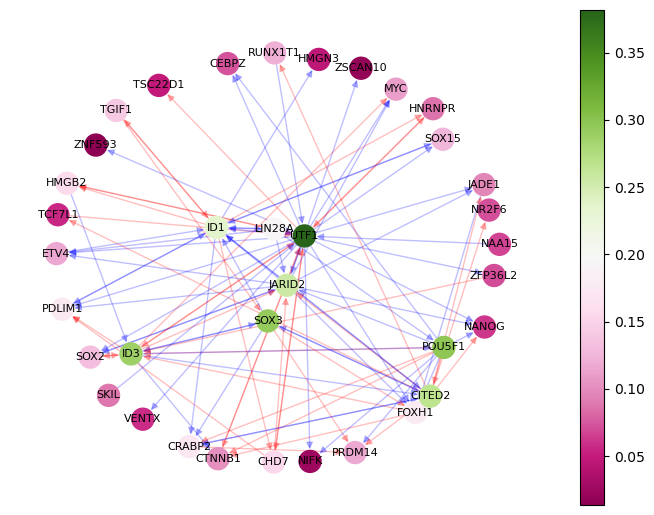

In [429]:
A = pd.DataFrame(np.asarray(estim_alt.A.clone()), index = adata_tf.var.index, columns = adata_tf.var.index)
import networkx as nx

g = nx.DiGraph(np.abs(A))
centralities = nx.centrality.eigenvector_centrality(g.reverse(), weight = 'weight') # calcualte first centrality without thresholding

thresh = np.quantile(np.abs(A.values), 0.99)
A[np.abs(A) <= thresh] = 0
g = nx.DiGraph(A)
g = nx.subgraph(g, max(nx.connected_components(nx.Graph(g)), key=len))

edge_colors = ['blue' if g[u][v]['weight'] > 0 else 'red' for u, v in g.edges()]

np.random.seed(42)
# nx.draw_nodes(g, with_labels = True, node_color = [centralities[x] for x in g.nodes], edge_color = edge_colors, node_size = 250, font_size = 8, cmap = "PiYG", pos=nx.shell_layout(g),)
pos = nx.spring_layout(g, iterations=250, k = 5)
plt.figure(figsize = (2*PLT_CELL, 1.5*PLT_CELL))
pc = nx.draw_networkx_nodes(g, node_color = [centralities[x] for x in g.nodes], node_size = 250, cmap = "PiYG", pos=pos)
plt.colorbar(pc)
nx.draw_networkx_labels(g, pos=pos, font_size=8);
nx.draw_networkx_edges(g, edge_color=edge_colors, pos = pos, alpha = 0.25);
plt.axis("off")
plt.tight_layout()
plt.savefig("../figures/scCRISPR_net_graph.pdf")

/tmp/ipykernel_928420/2449705989.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels);


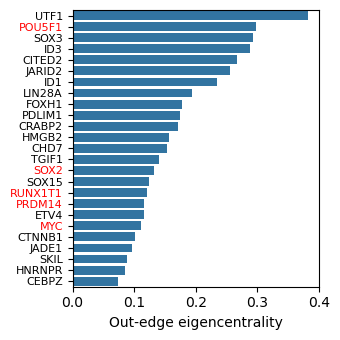

In [433]:
A = pd.DataFrame(np.asarray(estim_alt.A.clone()), index = adata_tf.var.index, columns = adata_tf.var.index)
g = nx.DiGraph(np.abs(A))
centralities = nx.centrality.eigenvector_centrality(g.reverse(), weight = 'weight') # calcualte first centrality without thresholding
_centralities = pd.Series(centralities)
plt.figure(figsize = (PLT_CELL, PLT_CELL))
sb.barplot(_centralities.sort_values()[::-1][:25], orient = 'h')
plt.yticks(fontsize=8);
ax = plt.gca()
y_ticks = ax.get_yticks()
y_tick_labels = ax.get_yticklabels()
for label in y_tick_labels:
    if label.get_text() in _kos:
        label.set_color('red')
ax.set_yticklabels(y_tick_labels);
plt.xlabel("Out-edge eigencentrality")
plt.tight_layout()
plt.savefig("../figures/scCRISPR_centrality.pdf")

/tmp/ipykernel_928420/533647229.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels);


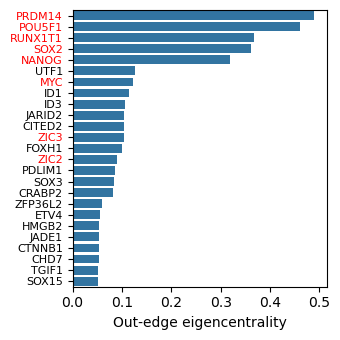

In [434]:
g = nx.DiGraph(np.abs(A_renge.copy()))
centralities = nx.centrality.eigenvector_centrality(g.reverse(), weight = 'weight') # calcualte first centrality without thresholding
_centralities = pd.Series(centralities)
plt.figure(figsize = (PLT_CELL, PLT_CELL))
sb.barplot(_centralities.sort_values()[::-1][:25], orient = 'h')
plt.yticks(fontsize=8);
ax = plt.gca()
y_ticks = ax.get_yticks()
y_tick_labels = ax.get_yticklabels()
for label in y_tick_labels:
    if label.get_text() in _kos:
        label.set_color('red')
ax.set_yticklabels(y_tick_labels);
plt.xlabel("Out-edge eigencentrality")
plt.tight_layout()
plt.savefig("../figures/scCRISPR_centrality_renge.pdf")

In [413]:
# Construct reference 
refs = {}
for f in glob.glob("chip_1kb/*.tsv"):
    gene = os.path.splitext(os.path.basename(f))[0].split(".")[0]
    df = pd.read_csv(f, sep = "\t")
    df.index = df.Target_genes
    # if len(df.columns[df.columns.str.contains("iPS_cells|ES_cells")]) == 0:
    #     print(pd.unique(df.columns.str.split("|").str[1]))
    y = pd.Series(df.loc[:, df.columns.str.contains("iPS_cells")].values.mean(-1), index = df.index)
    # y = pd.Series(df.iloc[:, 2:].values.mean(-1), index = df.index) 
    # y = pd.Series(df.iloc[:, 1], index = df.index) 
    refs[gene] = y

/tmp/ipykernel_928420/3847664451.py:9: RuntimeWarning: Mean of empty slice.
  y = pd.Series(df.loc[:, df.columns.str.contains("iPS_cells")].values.mean(-1), index = df.index)
/home/syz/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/syz/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_928420/3847664451.py:9: RuntimeWarning: Mean of empty slice.
  y = pd.Series(df.loc[:, df.columns.str.contains("iPS_cells")].values.mean(-1), index = df.index)
/home/syz/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/syz/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_928420/3847664451

In [414]:
A_ref = pd.DataFrame(refs).T
A_ref[np.isnan(A_ref.values)] = 0

In [415]:
_A = pd.DataFrame(estim_alt.A, index = adata_tf.var.index, columns=adata_tf.var.index)
_A_wt = pd.DataFrame(estim_wt.A, index = adata_tf.var.index, columns=adata_tf.var.index)

In [416]:
genes_common = pd.Index(set(A_ref.columns).intersection(set(_A.index)))
tfs = A_ref.index
tfs_no_ko = [i for i in tfs if i not in _kos]
tfs_ko = [i for i in tfs if i in _kos]

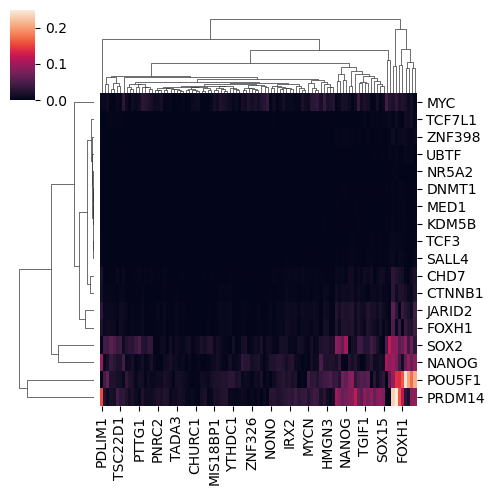

In [417]:
cg = sb.clustermap(A_renge.loc[tfs, genes_common].abs(), figsize = (5, 5))

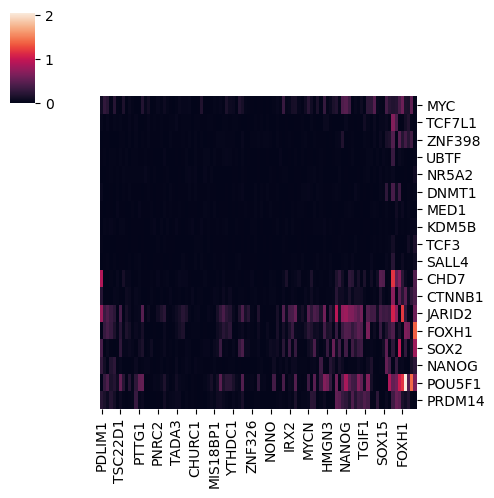

In [418]:
sb.clustermap(_A.loc[tfs, genes_common].abs().iloc[cg.dendrogram_row.reordered_ind, cg.dendrogram_col.reordered_ind], figsize = (5, 5), row_cluster = False, col_cluster= False)

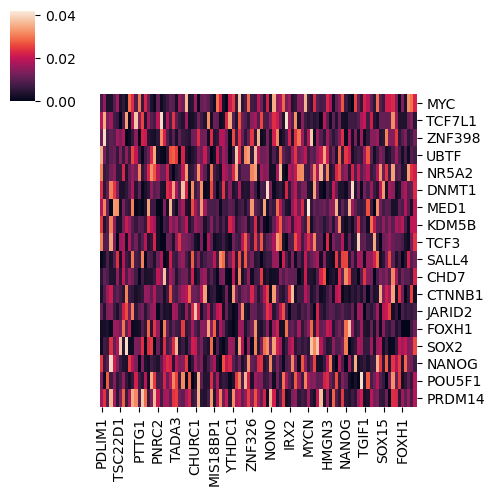

In [419]:
sb.clustermap(_A_wt.loc[tfs, genes_common].abs().iloc[cg.dendrogram_row.reordered_ind, cg.dendrogram_col.reordered_ind], figsize = (5, 5), row_cluster = False, col_cluster= False)

In [420]:
_tfs = tfs
_thresh = 0

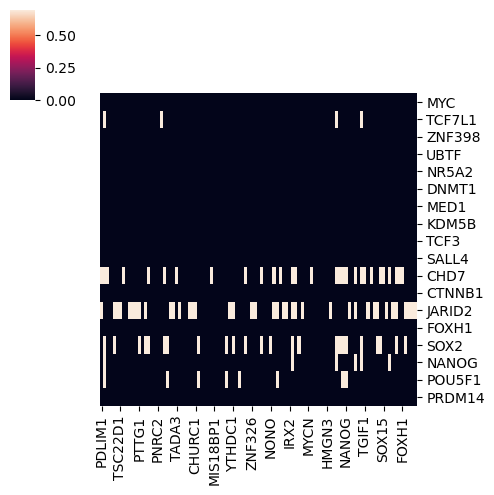

In [421]:
sb.clustermap(np.log1p(A_ref > _thresh).loc[tfs, genes_common].iloc[cg.dendrogram_row.reordered_ind, cg.dendrogram_col.reordered_ind], figsize = (5, 5), row_cluster = False, col_cluster= False)

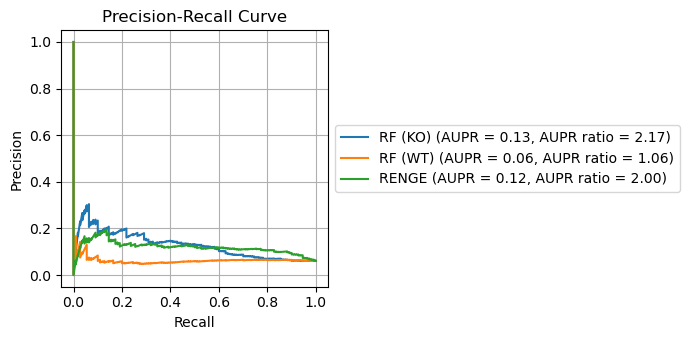

In [422]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
ys = {}
y_true = (A_ref.loc[_tfs, genes_common] > _thresh).values.flatten()
ys["RF (KO)"] = np.abs(_A.loc[_tfs, genes_common]).values.flatten()
ys["RF (WT)"] = np.abs(_A_wt.loc[_tfs, genes_common]).values.flatten()
ys["RENGE"] = np.abs(A_renge.loc[_tfs, genes_common]).values.flatten()

plt.figure(figsize = (2*PLT_CELL, PLT_CELL))
for (k, y) in ys.items():
    prec, rec, thresh = precision_recall_curve(y_true, y)
    avg_prec = average_precision_score(y_true, y)
    plt.plot(rec, prec, label=f'{k} (AUPR = {avg_prec:.2f}, AUPR ratio = {avg_prec / y_true.mean():.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.savefig("../figures/scCRISPR_AUPR.pdf")